# Week 3: MuSe 数据集特征提取和基线模型

---

## 📋 任务概述 (Task Overview)

本 notebook 完成 MuSe 数据集的特征提取和基线模型训练。

### 🎯 目标 (Objectives)
1. 匹配音频文件和 V-A-D 标注
2. 提取传统音频特征 (MFCC, Chroma, Spectral, Rhythm)
3. 训练基线回归模型
4. 与 DEAM 数据集结果对比

### 📊 数据 (Data)
- **音频数量**: 953 首 (已清洗)
- **音频时长**: 30 秒
- **标注维度**: Valence, Arousal, Dominance (V-A-D)
- **数据源**: `audio_clips_1000/` + `muse_sampled_1000.csv`

### 🤖 模型 (Models)
- Linear Regression
- Ridge Regression
- Random Forest

### 📈 评估指标 (Metrics)
- **R²** (决定系数 / Coefficient of Determination)
- **MSE** (均方误差 / Mean Squared Error)
- **MAE** (平均绝对误差 / Mean Absolute Error)
- **RMSE** (均方根误差 / Root Mean Squared Error)
- **CCC** (一致性相关系数 / Concordance Correlation Coefficient)

---


## 1. 导入库和设置 (Import Libraries and Setup)


In [41]:
# 数据处理
import pandas as pd
import numpy as np
from pathlib import Path
import librosa
import librosa.display
from tqdm import tqdm
import sys

# 添加项目路径以导入自定义模块
sys.path.append('..')

# 导入自定义特征提取模块 (使用与DEAM相同的133维特征)
from src.features.traditional import extract_all_features, get_feature_names

# 机器学习
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns

# 设置
import warnings
warnings.filterwarnings('ignore')

# 随机种子
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 可视化设置
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

print("=" * 70)
print("✅ 库导入成功 (Libraries imported successfully)")
print("=" * 70)
print(f"Librosa版本: {librosa.__version__}")
print(f"随机种子 (Random seed): {RANDOM_STATE}")
print(f"\n🎯 特征提取: 使用 133 维特征 (与 DEAM 相同)")
print(f"   - MFCC: 20×3 = 60 维")
print(f"   - Chroma: 12×4 = 48 维")
print(f"   - Spectral: 22 维")
print(f"   - Rhythm: 3 维")


✅ 库导入成功 (Libraries imported successfully)
Librosa版本: 0.11.0
随机种子 (Random seed): 42

🎯 特征提取: 使用 133 维特征 (与 DEAM 相同)
   - MFCC: 20×3 = 60 维
   - Chroma: 12×4 = 48 维
   - Spectral: 22 维
   - Rhythm: 3 维


## 2. 加载和匹配数据 (Load and Match Data)


In [42]:
print("=" * 70)
print("📋 加载音频文件和标注数据")
print("=" * 70)

# 1. 设置路径
AUDIO_DIR = Path('../data/MuSe/audio_clips_1000')
ANNOTATION_PATH = Path('../data/MuSe/processed/muse_sampled_1000.csv')
OUTPUT_DIR = Path('../data/MuSe/processed')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# 2. 加载标注数据
df_annotations = pd.read_csv(ANNOTATION_PATH)
print(f"\n✅ 加载标注数据: {len(df_annotations)} 条记录")

# 3. 获取所有音频文件
audio_files = sorted(AUDIO_DIR.glob('*.mp3'))
print(f"✅ 找到音频文件: {len(audio_files)} 个")

# 4. 匹配音频和标注
matched_data = []
for audio_file in audio_files:
    # 提取序号 (0001 -> 1)
    file_idx = int(audio_file.stem.split('-')[0])
    
    # 获取对应的标注
    if file_idx <= len(df_annotations):
        row = df_annotations.iloc[file_idx - 1]
        
        matched_data.append({
            'file_path': str(audio_file),
            'file_name': audio_file.name,
            'song_id': file_idx,
            'track': row['track'],
            'artist': row['artist'],
            'valence': row['valence_tags'],
            'arousal': row['arousal_tags'],
            'dominance': row['dominance_tags'],
            'genre': row['genre'],
            'spotify_id': row['spotify_id']
        })

# 创建匹配后的 DataFrame
df_matched = pd.DataFrame(matched_data)
print(f"\n✅ 成功匹配: {len(df_matched)} 条数据")

# 5. 保存匹配结果
matched_output_path = OUTPUT_DIR / 'muse_audio_matched.csv'
df_matched.to_csv(matched_output_path, index=False)
print(f"💾 保存匹配结果: {matched_output_path}")

# 6. 显示统计信息
print(f"\n📊 V-A-D 统计:")
print(f"   Valence   - 均值: {df_matched['valence'].mean():.3f}, 标准差: {df_matched['valence'].std():.3f}, 范围: [{df_matched['valence'].min():.2f}, {df_matched['valence'].max():.2f}]")
print(f"   Arousal   - 均值: {df_matched['arousal'].mean():.3f}, 标准差: {df_matched['arousal'].std():.3f}, 范围: [{df_matched['arousal'].min():.2f}, {df_matched['arousal'].max():.2f}]")
print(f"   Dominance - 均值: {df_matched['dominance'].mean():.3f}, 标准差: {df_matched['dominance'].std():.3f}, 范围: [{df_matched['dominance'].min():.2f}, {df_matched['dominance'].max():.2f}]")

# 7. 显示前5条数据
print(f"\n📋 前5条匹配数据:")
df_matched[['file_name', 'artist', 'track', 'valence', 'arousal', 'dominance']].head()


📋 加载音频文件和标注数据

✅ 加载标注数据: 1000 条记录
✅ 找到音频文件: 942 个

✅ 成功匹配: 942 条数据
💾 保存匹配结果: ..\data\MuSe\processed\muse_audio_matched.csv

📊 V-A-D 统计:
   Valence   - 均值: 5.437, 标准差: 1.590, 范围: [0.64, 8.47]
   Arousal   - 均值: 4.256, 标准差: 1.170, 范围: [0.69, 7.27]
   Dominance - 均值: 5.242, 标准差: 1.216, 范围: [0.68, 7.32]

📋 前5条匹配数据:


,file_name,artist,track,valence,arousal,dominance
0,0001-Blackstreet-Falling In Love Again.mp3,Blackstreet,Falling In Love Again,7.353333,6.370000,6.306667
1,0002-Madonna-Justify My Love porno mix Rare.mp3,Lucifers Crossing,Blasphemer,3.172857,4.494286,3.468571
2,0003-Aimee Mann-One.mp3,Madonna,Justify My Love (porno mix) Rare,6.640000,6.950000,7.000000
3,0004-Linkin Park-Roads Untraveled.mp3,Aimee Mann,One,4.683675,3.500171,5.018205
4,0005-Nits-Two Skaters.mp3,Linkin Park,Roads Untraveled,3.652632,3.982105,4.387368


## 3. 定义特征提取函数 (Define Feature Extraction Functions)


In [43]:
# 使用与 DEAM 相同的 133 维特征提取函数
# 该函数定义在 src/features/traditional.py 中，已在 Cell 2 中导入

print("=" * 70)
print("✅ 特征提取函数配置完成")
print("=" * 70)
print("\n🎯 使用 133 维特征提取 (与 DEAM 相同):")
print("\n📊 特征类型分布:")
print("   • MFCC:")
print("     - mfcc_mean: 20 维")
print("     - mfcc_std: 20 维")
print("     - mfcc_delta_mean: 20 维 (一阶差分)")
print("     小计: 60 维")
print("\n   • Chroma:")
print("     - chroma_stft_mean: 12 维")
print("     - chroma_stft_std: 12 维")
print("     - chroma_cqt_mean: 12 维 (Constant-Q Transform)")
print("     - chroma_cqt_std: 12 维")
print("     小计: 48 维")
print("\n   • Spectral:")
print("     - spectral_centroid: mean + std = 2 维")
print("     - spectral_rolloff: mean + std = 2 维")
print("     - spectral_bandwidth: mean + std = 2 维")
print("     - zero_crossing_rate: mean + std = 2 维")
print("     - spectral_contrast: 7频段 × 2 = 14 维")
print("     小计: 22 维")
print("\n   • Rhythm:")
print("     - tempo: 1 维")
print("     - beat_count: 1 维")
print("     - beat_strength: 1 维")
print("     小计: 3 维")
print("\n" + "=" * 70)
print("✅ 总计: 60 + 48 + 22 + 3 = 133 维特征")
print("=" * 70)
print("\n💡 对比:")
print("   • MuSe (旧版): 75 维")
print("   • MuSe (新版): 133 维 ← 当前")
print("   • DEAM: 133 维 ✅")
print("\n✅ 现在可以进行公平对比！")


✅ 特征提取函数配置完成

🎯 使用 133 维特征提取 (与 DEAM 相同):

📊 特征类型分布:
   • MFCC:
     - mfcc_mean: 20 维
     - mfcc_std: 20 维
     - mfcc_delta_mean: 20 维 (一阶差分)
     小计: 60 维

   • Chroma:
     - chroma_stft_mean: 12 维
     - chroma_stft_std: 12 维
     - chroma_cqt_mean: 12 维 (Constant-Q Transform)
     - chroma_cqt_std: 12 维
     小计: 48 维

   • Spectral:
     - spectral_centroid: mean + std = 2 维
     - spectral_rolloff: mean + std = 2 维
     - spectral_bandwidth: mean + std = 2 维
     - zero_crossing_rate: mean + std = 2 维
     - spectral_contrast: 7频段 × 2 = 14 维
     小计: 22 维

   • Rhythm:
     - tempo: 1 维
     - beat_count: 1 维
     - beat_strength: 1 维
     小计: 3 维

✅ 总计: 60 + 48 + 22 + 3 = 133 维特征

💡 对比:
   • MuSe (旧版): 75 维
   • MuSe (新版): 133 维 ← 当前
   • DEAM: 133 维 ✅

✅ 现在可以进行公平对比！


## 4. 批量提取特征 (Batch Feature Extraction)

**⚠️ 注意**: 这一步会花费约 **45-60 分钟** (953首 × 3秒/首)


In [44]:
print("=" * 70)
print("🎵 开始批量特征提取 (133 维特征)")
print("=" * 70)
print(f"\n总数: {len(df_matched)} 首")
print(f"估计时间: 约 {len(df_matched) * 4 / 60:.0f} 分钟 (每首约4秒，133维特征需要更多时间)")
print("\n💡 提示:")
print("   • 可随时中断 (Ctrl+C)")
print("   • 提取的特征包含更多信息:")
print("     - MFCC Delta (动态变化)")
print("     - Chroma CQT (更精确的音高)")
print("     - Beat Count & Strength (节奏强度)")
print("\n⏱️  开始提取...\n")

# 存储特征
all_features = []
failed_count = 0

# 批量提取
for idx, row in tqdm(df_matched.iterrows(), total=len(df_matched), desc="提取进度"):
    try:
        # 使用 extract_all_features 提取 133 维特征
        features_dict = extract_all_features(
            audio_path=row['file_path'],
            sr=22050,
            hop_length=512,
            n_mfcc=20  # DEAM 使用 20 个 MFCC 系数
        )
        
        if features_dict is not None and len(features_dict) > 0:
            # 创建记录
            record = {
                'song_id': row['song_id'],
                'file_name': row['file_name'],
                'valence': row['valence'],
                'arousal': row['arousal'],
                'dominance': row['dominance']
            }
            
            # 添加所有特征
            record.update(features_dict)
            
            all_features.append(record)
        else:
            failed_count += 1
            print(f"   ❌ 提取失败: {row['file_name']}")
            
    except Exception as e:
        failed_count += 1
        print(f"   ❌ 提取失败: {row['file_name']} | Error: {str(e)[:50]}...")

# 创建特征 DataFrame
df_features = pd.DataFrame(all_features)

# 计算特征数量
feature_cols = [c for c in df_features.columns if c not in ['song_id', 'file_name', 'valence', 'arousal', 'dominance']]
n_features = len(feature_cols)

print("\n" + "=" * 70)
print("✅ 特征提取完成")
print("=" * 70)
print(f"   成功: {len(df_features)} 首")
print(f"   失败: {failed_count} 首")
print(f"   特征维度: {n_features} 维")

# 验证特征数量
if n_features == 133:
    print(f"\n✅ 特征数量验证通过: {n_features} 维 = 133 维 (与 DEAM 相同)")
else:
    print(f"\n⚠️  特征数量: {n_features} 维 (预期 133 维)")

# 保存特征 (使用新文件名，避免覆盖旧的 75 维特征)
features_output_path = OUTPUT_DIR / 'muse_features_all_133dim.csv'
df_features.to_csv(features_output_path, index=False)
print(f"\n💾 保存特征文件: {features_output_path}")
print(f"   (旧的 75 维特征保存在: muse_features_all.csv)")

# 显示前几行
print(f"\n📋 特征数据预览:")
print(df_features[['song_id', 'file_name', 'valence', 'arousal', 'dominance'] + feature_cols[:5]].head())


🎵 开始批量特征提取 (133 维特征)

总数: 942 首
估计时间: 约 63 分钟 (每首约4秒，133维特征需要更多时间)

💡 提示:
   • 可随时中断 (Ctrl+C)
   • 提取的特征包含更多信息:
     - MFCC Delta (动态变化)
     - Chroma CQT (更精确的音高)
     - Beat Count & Strength (节奏强度)

⏱️  开始提取...



提取进度: 100%|██████████| 942/942 [15:26<00:00,  1.02it/s]


✅ 特征提取完成
   成功: 942 首
   失败: 0 首
   特征维度: 133 维

✅ 特征数量验证通过: 133 维 = 133 维 (与 DEAM 相同)

💾 保存特征文件: ..\data\MuSe\processed\muse_features_all_133dim.csv
   (旧的 75 维特征保存在: muse_features_all.csv)

📋 特征数据预览:
   song_id                                        file_name   valence  \
0        1       0001-Blackstreet-Falling In Love Again.mp3  7.353333   
1        2  0002-Madonna-Justify My Love porno mix Rare.mp3  3.172857   
2        3                          0003-Aimee Mann-One.mp3  6.640000   
3        4            0004-Linkin Park-Roads Untraveled.mp3  4.683675   
4        5                        0005-Nits-Two Skaters.mp3  3.652632   

    arousal  dominance  mfcc_mean_0  mfcc_mean_1  mfcc_mean_2  mfcc_mean_3  \
0  6.370000   6.306667  -108.028145    76.541893    31.703379     8.499625   
1  4.494286   3.468571  -195.036621    97.469704    28.823811    27.856121   
2  6.950000   7.000000  -202.806183   144.974579     0.264401    16.066132   
3  3.500171   5.018205  -168.246765    58.1420

---

## 🎯 重要更新：133 维特征

**升级说明：**

本 notebook 已升级为提取 **133 维特征**（与 DEAM 相同），替代之前的 75 维特征。

### 📊 对比

| 版本 | 特征数 | 文件名 | 说明 |
|------|--------|--------|------|
| **旧版** | 75 维 | `muse_features_all.csv` | 简化版特征 |
| **新版** | 133 维 | `muse_features_all_133dim.csv` | ✅ 当前，与 DEAM 相同 |

### 🔧 后续步骤

**使用新特征文件进行模型训练：**

在 `05_muse_baseline_models.ipynb` 中：
```python
# 修改加载路径
DATA_PATH = BASE_DIR / 'data' / 'MuSe' / 'processed' / 'muse_features_all_133dim.csv'
```

### ✅ 优势

1. **公平对比**：与 DEAM 使用相同的特征提取方法
2. **更丰富的信息**：
   - MFCC Delta（捕捉动态变化）
   - Chroma CQT（更精确的音高特征）
   - Beat Strength（节奏强度）
3. **更强的表达能力**：133维 > 75维

### 📝 预期效果

即使升级到 133 维，预计 MuSe 的 R² 仍然会远低于 DEAM，因为：
- **标签质量** 是主要瓶颈（社交标签 vs 专家标注）
- 特征数量提升可能带来 **微小改善**（R² = 0.02 → 0.03-0.04）
- 但仍然无法达到 DEAM 的水平（R² = 0.51）

### 🚀 接下来

1. ✅ 运行 Cell 8 提取 133 维特征（~60分钟）
2. ⏳ 使用新特征文件重新训练模型
3. 📊 对比 75 维 vs 133 维的性能差异
4. 📝 更新报告，强调"标签质量 > 特征数量"

---


## 5. 数据分割 (Data Splitting)


In [58]:
print("=" * 70)
print("📊 数据分割 (Train/Validation/Test)")
print("=" * 70)

# 准备特征和标签
# 排除非特征列（ID、文件名、标签）
non_feature_cols = ['song_id', 'file_name', 'valence', 'arousal', 'dominance']
feature_cols = [c for c in df_features.columns if c not in non_feature_cols]

print(f"\n📋 特征列类型:")
print(f"   总列数: {len(df_features.columns)}")
print(f"   特征列数: {len(feature_cols)}")
print(f"   前5个特征: {feature_cols[:5]}")
print(f"   后5个特征: {feature_cols[-5:]}")

X = df_features[feature_cols].values
y_valence = df_features['valence'].values
y_arousal = df_features['arousal'].values
y_dominance = df_features['dominance'].values

print(f"\n📊 数据维度:")
print(f"   特征矩阵 X: {X.shape}")
print(f"   目标 Valence: {y_valence.shape}")
print(f"   目标 Arousal: {y_arousal.shape}")
print(f"   目标 Dominance: {y_dominance.shape}")

# 数据分割: 70% 训练, 15% 验证, 15% 测试
X_temp, X_test, y_v_temp, y_v_test, y_a_temp, y_a_test, y_d_temp, y_d_test = train_test_split(
    X, y_valence, y_arousal, y_dominance, 
    test_size=0.15, 
    random_state=RANDOM_STATE
)

X_train, X_val, y_v_train, y_v_val, y_a_train, y_a_val, y_d_train, y_d_val = train_test_split(
    X_temp, y_v_temp, y_a_temp, y_d_temp,
    test_size=0.176,  # 0.176 * 0.85 ≈ 0.15
    random_state=RANDOM_STATE
)

print(f"\n📊 数据集大小:")
print(f"   训练集 (Train):      {X_train.shape[0]} 首 ({X_train.shape[0]/len(df_features)*100:.1f}%)")
print(f"   验证集 (Validation): {X_val.shape[0]} 首 ({X_val.shape[0]/len(df_features)*100:.1f}%)")
print(f"   测试集 (Test):       {X_test.shape[0]} 首 ({X_test.shape[0]/len(df_features)*100:.1f}%)")
print(f"   总计:                {len(df_features)} 首")


📊 数据分割 (Train/Validation/Test)

📋 特征列类型:
   总列数: 138
   特征列数: 133
   前5个特征: ['mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4']
   后5个特征: ['zcr_mean', 'zcr_std', 'tempo', 'beat_count', 'beat_strength']

📊 数据维度:
   特征矩阵 X: (942, 133)
   目标 Valence: (942,)
   目标 Arousal: (942,)
   目标 Dominance: (942,)

📊 数据集大小:
   训练集 (Train):      659 首 (70.0%)
   验证集 (Validation): 141 首 (15.0%)
   测试集 (Test):       142 首 (15.1%)
   总计:                942 首


## 6. 特征标准化 (Feature Standardization)


In [59]:
print("=" * 70)
print("🔧 特征标准化 (Feature Scaling)")
print("=" * 70)

# 使用训练集拟合 Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ 标准化完成")
print(f"\n标准化后的特征统计 (训练集):")
print(f"   均值: {X_train_scaled.mean():.6f}")
print(f"   标准差: {X_train_scaled.std():.6f}")
print(f"   最小值: {X_train_scaled.min():.3f}")
print(f"   最大值: {X_train_scaled.max():.3f}")


🔧 特征标准化 (Feature Scaling)

✅ 标准化完成

标准化后的特征统计 (训练集):
   均值: -0.000000
   标准差: 1.000000
   最小值: -7.832
   最大值: 10.080


## 🔍 6. 数据质量诊断

在训练模型之前，先检查特征和标签的质量，确保数据没有异常。


In [60]:
# 方案 1: 检查数据质量
print("=" * 70)
print("🔍 数据质量检查 (Data Quality Check)")
print("=" * 70)

# 检查特征统计
print("\n📊 特征统计 (Feature Statistics):")
print(f"   特征数量: {X_train_scaled.shape[1]}")
print(f"   样本数量: {X_train_scaled.shape[0]}")
print(f"   特征范围: min={X_train_scaled.min():.4f}, max={X_train_scaled.max():.4f}")
print(f"   特征均值: {X_train_scaled.mean():.4f}")
print(f"   特征标准差: {X_train_scaled.std():.4f}")
print(f"   是否有 NaN: {np.isnan(X_train_scaled).any()}")
print(f"   是否有 Inf: {np.isinf(X_train_scaled).any()}")

# 检查标签统计
print("\n📊 标签统计 (Label Statistics):")
for target_name, target_data in [
    ('Valence', y_v_train), 
    ('Arousal', y_a_train), 
    ('Dominance', y_d_train)
]:
    print(f"\n   {target_name}:")
    print(f"      均值 (mean): {target_data.mean():.3f}")
    print(f"      标准差 (std): {target_data.std():.3f}")
    print(f"      范围 (range): [{target_data.min():.2f}, {target_data.max():.2f}]")
    print(f"      方差 (variance): {target_data.var():.3f}")
    print(f"      中位数 (median): {np.median(target_data):.3f}")

# 检查训练集和测试集的分布
print("\n📊 训练/测试集分布对比 (Train/Test Distribution):")
print(f"\n   Valence:")
print(f"      训练集均值: {y_v_train.mean():.3f} | 测试集均值: {y_v_test.mean():.3f}")
print(f"      训练集标准差: {y_v_train.std():.3f} | 测试集标准差: {y_v_test.std():.3f}")

print(f"\n   Arousal:")
print(f"      训练集均值: {y_a_train.mean():.3f} | 测试集均值: {y_a_test.mean():.3f}")
print(f"      训练集标准差: {y_a_train.std():.3f} | 测试集标准差: {y_a_test.std():.3f}")

print(f"\n   Dominance:")
print(f"      训练集均值: {y_d_train.mean():.3f} | 测试集均值: {y_d_test.mean():.3f}")
print(f"      训练集标准差: {y_d_train.std():.3f} | 测试集标准差: {y_d_test.std():.3f}")

# 检查原始特征（标准化之前）
print("\n📊 原始特征统计 (Original Features - before scaling):")
print(f"   特征范围: min={X.min():.2f}, max={X.max():.2f}")
print(f"   特征均值: {X.mean():.2f}")
print(f"   特征标准差: {X.std():.2f}")

print("\n✅ 数据质量检查完成")


🔍 数据质量检查 (Data Quality Check)

📊 特征统计 (Feature Statistics):
   特征数量: 133
   样本数量: 659
   特征范围: min=-7.8316, max=10.0796
   特征均值: -0.0000
   特征标准差: 1.0000
   是否有 NaN: False
   是否有 Inf: False

📊 标签统计 (Label Statistics):

   Valence:
      均值 (mean): 5.455
      标准差 (std): 1.590
      范围 (range): [0.64, 8.47]
      方差 (variance): 2.529
      中位数 (median): 5.769

   Arousal:
      均值 (mean): 4.273
      标准差 (std): 1.154
      范围 (range): [0.69, 7.27]
      方差 (variance): 1.333
      中位数 (median): 4.264

   Dominance:
      均值 (mean): 5.247
      标准差 (std): 1.216
      范围 (range): [0.68, 7.32]
      方差 (variance): 1.478
      中位数 (median): 5.485

📊 训练/测试集分布对比 (Train/Test Distribution):

   Valence:
      训练集均值: 5.455 | 测试集均值: 5.496
      训练集标准差: 1.590 | 测试集标准差: 1.554

   Arousal:
      训练集均值: 4.273 | 测试集均值: 4.306
      训练集标准差: 1.154 | 测试集标准差: 1.227

   Dominance:
      训练集均值: 5.247 | 测试集均值: 5.350
      训练集标准差: 1.216 | 测试集标准差: 1.132

📊 原始特征统计 (Original Features - before scaling):
   特征范围: mi

### 📊 Baseline 测试：均值预测器

使用最简单的预测器（直接预测均值）作为 baseline，看看我们的模型是否比这个 baseline 更好。

**理论上：**
- 均值预测器的 R² = 0
- 如果模型 R² > 0，说明模型有效
- 如果模型 R² < 0，说明模型比均值预测还差


In [61]:
# 方案 2: 使用均值预测器测试 baseline
from sklearn.dummy import DummyRegressor

print("=" * 70)
print("🧪 Baseline 测试：均值预测器 (Dummy Regressor)")
print("=" * 70)

baseline_results = []

for target_name, y_train, y_test in [
    ('Valence', y_v_train, y_v_test),
    ('Arousal', y_a_train, y_a_test),
    ('Dominance', y_d_train, y_d_test)
]:
    # 均值预测器
    dummy = DummyRegressor(strategy='mean')
    dummy.fit(X_train_scaled, y_train)
    y_pred = dummy.predict(X_test_scaled)
    
    # 计算指标
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"\n📊 {target_name} (均值预测器):")
    print(f"   R²: {r2:.4f}")
    print(f"   MSE: {mse:.4f}")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   MAE: {mae:.4f}")
    print(f"   预测值: 所有都是 {y_pred[0]:.3f} (训练集均值)")
    print(f"   真实值范围: [{y_test.min():.2f}, {y_test.max():.2f}]")
    
    baseline_results.append({
        'Target': target_name,
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    })

print("\n" + "=" * 70)
print("✅ Baseline 测试完成")
print("=" * 70)
print("\n💡 理论期望:")
print("   • 均值预测器的 R² 应该 ≈ 0")
print("   • 如果我们的模型 R² < 0，说明模型比均值预测还差")
print("   • 如果我们的模型 R² > 0，说明模型有效")

# 保存 baseline 结果供后续对比
df_baseline = pd.DataFrame(baseline_results)
display(df_baseline)


🧪 Baseline 测试：均值预测器 (Dummy Regressor)

📊 Valence (均值预测器):
   R²: -0.0007
   MSE: 2.4171
   RMSE: 1.5547
   MAE: 1.2926
   预测值: 所有都是 5.455 (训练集均值)
   真实值范围: [1.92, 8.02]

📊 Arousal (均值预测器):
   R²: -0.0007
   MSE: 1.5054
   RMSE: 1.2269
   MAE: 0.9725
   预测值: 所有都是 4.273 (训练集均值)
   真实值范围: [0.83, 6.95]

📊 Dominance (均值预测器):
   R²: -0.0083
   MSE: 1.2919
   RMSE: 1.1366
   MAE: 0.9349
   预测值: 所有都是 5.247 (训练集均值)
   真实值范围: [1.67, 7.32]

✅ Baseline 测试完成

💡 理论期望:
   • 均值预测器的 R² 应该 ≈ 0
   • 如果我们的模型 R² < 0，说明模型比均值预测还差
   • 如果我们的模型 R² > 0，说明模型有效


,Target,R²,MSE,RMSE,MAE
0,Valence,-0.000701,2.417123,1.554710,1.292563
1,Arousal,-0.000695,1.505355,1.226929,0.972473
2,Dominance,-0.008275,1.291944,1.136637,0.934891


---

## 7. 训练 Baseline 模型

现在开始训练实际的机器学习模型，并与上面的均值预测器进行对比。


## 7. 训练基线模型 (Train Baseline Models)

我们将训练3个维度的回归模型：
1. **Valence** (愉悦度)
2. **Arousal** (唤醒度)
3. **Dominance** (支配度) ← MuSe 独有

### 定义评估函数


In [62]:
def concordance_correlation_coefficient(y_true, y_pred):
    """
    计算 Lin's Concordance Correlation Coefficient (CCC)
    
    CCC 是情感识别任务中的标准评估指标，用于衡量预测值和真实值的一致性。
    
    参数:
        y_true: 真实值
        y_pred: 预测值
    
    返回:
        ccc: CCC值，范围 [-1, 1]，1 表示完美一致
    
    公式:
        CCC = 2 * ρ * σ_x * σ_y / (σ_x² + σ_y² + (μ_x - μ_y)²)
        其中:
            ρ = Pearson相关系数
            σ_x, σ_y = 标准差
            μ_x, μ_y = 均值
    """
    # 均值
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    
    # 方差
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    
    # 标准差
    std_true = np.std(y_true)
    std_pred = np.std(y_pred)
    
    # Pearson 相关系数
    pearson_corr = np.corrcoef(y_true, y_pred)[0, 1]
    
    # CCC
    ccc = 2 * pearson_corr * std_true * std_pred / (var_true + var_pred + (mean_true - mean_pred)**2)
    
    return ccc


# 定义评估函数
def evaluate_model(y_true, y_pred, model_name, target_name):
    """评估模型性能"""
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    ccc = concordance_correlation_coefficient(y_true, y_pred)  # 添加 CCC
    
    return {
        'Model': model_name,
        'Target': target_name,
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'CCC': ccc  # 添加 CCC
    }

print("✅ 评估函数定义完成（包含 CCC 指标）")


✅ 评估函数定义完成（包含 CCC 指标）


### 7.1 Valence 预测模型


In [63]:
print("=" * 70)
print("🎯 训练 Valence 预测模型 (检查过拟合)")
print("=" * 70)

results_valence = []

# 1. Linear Regression
print("\n1️⃣ Linear Regression...")
lr_v = LinearRegression()
lr_v.fit(X_train_scaled, y_v_train)
y_v_pred_lr_train = lr_v.predict(X_train_scaled)  # 训练集预测
y_v_pred_lr = lr_v.predict(X_test_scaled)         # 测试集预测
train_r2 = r2_score(y_v_train, y_v_pred_lr_train)
test_r2 = results_valence[-1]['R²'] if results_valence else r2_score(y_v_test, y_v_pred_lr)
results_valence.append(evaluate_model(y_v_test, y_v_pred_lr, 'Linear Regression', 'Valence'))
print(f"   训练集 R² = {train_r2:.4f} | 测试集 R² = {results_valence[-1]['R²']:.4f} | CCC = {results_valence[-1]['CCC']:.4f}")

# 2. Ridge Regression
print("\n2️⃣ Ridge Regression...")
ridge_v = Ridge(alpha=1.0, random_state=RANDOM_STATE)
ridge_v.fit(X_train_scaled, y_v_train)
y_v_pred_ridge_train = ridge_v.predict(X_train_scaled)
y_v_pred_ridge = ridge_v.predict(X_test_scaled)
train_r2 = r2_score(y_v_train, y_v_pred_ridge_train)
results_valence.append(evaluate_model(y_v_test, y_v_pred_ridge, 'Ridge', 'Valence'))
print(f"   训练集 R² = {train_r2:.4f} | 测试集 R² = {results_valence[-1]['R²']:.4f} | CCC = {results_valence[-1]['CCC']:.4f}")

# 3. Random Forest
print("\n3️⃣ Random Forest...")
rf_v = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1)
rf_v.fit(X_train_scaled, y_v_train)
y_v_pred_rf_train = rf_v.predict(X_train_scaled)
y_v_pred_rf = rf_v.predict(X_test_scaled)
train_r2 = r2_score(y_v_train, y_v_pred_rf_train)
results_valence.append(evaluate_model(y_v_test, y_v_pred_rf, 'Random Forest', 'Valence'))
print(f"   训练集 R² = {train_r2:.4f} | 测试集 R² = {results_valence[-1]['R²']:.4f} | CCC = {results_valence[-1]['CCC']:.4f}")

# 显示结果
df_results_v = pd.DataFrame(results_valence)
print("\n" + "=" * 70)
print("📊 Valence 预测结果 (测试集)")
print("=" * 70)
print("\n⚠️  如果训练集 R² 远大于测试集 R²，说明模型过拟合")
print("⚠️  如果训练集和测试集 R² 都很低，说明特征不足以预测标签")
df_results_v


🎯 训练 Valence 预测模型 (检查过拟合)

1️⃣ Linear Regression...
   训练集 R² = 0.1724 | 测试集 R² = -0.4443 | CCC = -0.0468

2️⃣ Ridge Regression...
   训练集 R² = 0.1723 | 测试集 R² = -0.4287 | CCC = -0.0471

3️⃣ Random Forest...
   训练集 R² = 0.7639 | 测试集 R² = -0.0575 | CCC = -0.0237

📊 Valence 预测结果 (测试集)

⚠️  如果训练集 R² 远大于测试集 R²，说明模型过拟合
⚠️  如果训练集和测试集 R² 都很低，说明特征不足以预测标签


,Model,Target,R²,MSE,RMSE,MAE,CCC
0,Linear Regression,Valence,-0.444285,3.488570,1.867771,1.522652,-0.046841
1,Ridge,Valence,-0.428686,3.450892,1.857658,1.515960,-0.047111
2,Random Forest,Valence,-0.057450,2.554198,1.598186,1.337323,-0.023663


### 7.2 Arousal 预测模型 (检查过拟合)


In [64]:
print("=" * 70)
print("🎯 训练 Arousal 预测模型 (检查过拟合)")
print("=" * 70)

results_arousal = []

# 1. Linear Regression
print("\n1️⃣ Linear Regression...")
lr_a = LinearRegression()
lr_a.fit(X_train_scaled, y_a_train)
y_a_pred_lr_train = lr_a.predict(X_train_scaled)
y_a_pred_lr = lr_a.predict(X_test_scaled)
train_r2 = r2_score(y_a_train, y_a_pred_lr_train)
results_arousal.append(evaluate_model(y_a_test, y_a_pred_lr, 'Linear Regression', 'Arousal'))
print(f"   训练集 R² = {train_r2:.4f} | 测试集 R² = {results_arousal[-1]['R²']:.4f} | CCC = {results_arousal[-1]['CCC']:.4f}")

# 2. Ridge Regression
print("\n2️⃣ Ridge Regression...")
ridge_a = Ridge(alpha=1.0, random_state=RANDOM_STATE)
ridge_a.fit(X_train_scaled, y_a_train)
y_a_pred_ridge_train = ridge_a.predict(X_train_scaled)
y_a_pred_ridge = ridge_a.predict(X_test_scaled)
train_r2 = r2_score(y_a_train, y_a_pred_ridge_train)
results_arousal.append(evaluate_model(y_a_test, y_a_pred_ridge, 'Ridge', 'Arousal'))
print(f"   训练集 R² = {train_r2:.4f} | 测试集 R² = {results_arousal[-1]['R²']:.4f} | CCC = {results_arousal[-1]['CCC']:.4f}")

# 3. Random Forest
print("\n3️⃣ Random Forest...")
rf_a = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1)
rf_a.fit(X_train_scaled, y_a_train)
y_a_pred_rf_train = rf_a.predict(X_train_scaled)
y_a_pred_rf = rf_a.predict(X_test_scaled)
train_r2 = r2_score(y_a_train, y_a_pred_rf_train)
results_arousal.append(evaluate_model(y_a_test, y_a_pred_rf, 'Random Forest', 'Arousal'))
print(f"   训练集 R² = {train_r2:.4f} | 测试集 R² = {results_arousal[-1]['R²']:.4f} | CCC = {results_arousal[-1]['CCC']:.4f}")

# 显示结果
df_results_a = pd.DataFrame(results_arousal)
print("\n" + "=" * 70)
print("📊 Arousal 预测结果 (测试集)")
print("=" * 70)
print("\n⚠️  训练集和测试集 R² 对比将揭示问题所在")
df_results_a


🎯 训练 Arousal 预测模型 (检查过拟合)

1️⃣ Linear Regression...
   训练集 R² = 0.1923 | 测试集 R² = -0.4854 | CCC = -0.1460

2️⃣ Ridge Regression...
   训练集 R² = 0.1922 | 测试集 R² = -0.4685 | CCC = -0.1432

3️⃣ Random Forest...
   训练集 R² = 0.7585 | 测试集 R² = -0.0741 | CCC = -0.0380

📊 Arousal 预测结果 (测试集)

⚠️  训练集和测试集 R² 对比将揭示问题所在


,Model,Target,R²,MSE,RMSE,MAE,CCC
0,Linear Regression,Arousal,-0.485376,2.234465,1.494813,1.183746,-0.146029
1,Ridge,Arousal,-0.468469,2.209031,1.486281,1.178349,-0.143153
2,Random Forest,Arousal,-0.074116,1.615803,1.271142,1.002192,-0.037957


### 7.3 Dominance 预测模型 (MuSe 独有) - 检查过拟合


In [65]:
print("=" * 70)
print("🎯 训练 Dominance 预测模型 (MuSe 独有维度 - 检查过拟合)")
print("=" * 70)

results_dominance = []

# 1. Linear Regression
print("\n1️⃣ Linear Regression...")
lr_d = LinearRegression()
lr_d.fit(X_train_scaled, y_d_train)
y_d_pred_lr_train = lr_d.predict(X_train_scaled)
y_d_pred_lr = lr_d.predict(X_test_scaled)
train_r2 = r2_score(y_d_train, y_d_pred_lr_train)
results_dominance.append(evaluate_model(y_d_test, y_d_pred_lr, 'Linear Regression', 'Dominance'))
print(f"   训练集 R² = {train_r2:.4f} | 测试集 R² = {results_dominance[-1]['R²']:.4f} | CCC = {results_dominance[-1]['CCC']:.4f}")

# 2. Ridge Regression
print("\n2️⃣ Ridge Regression...")
ridge_d = Ridge(alpha=1.0, random_state=RANDOM_STATE)
ridge_d.fit(X_train_scaled, y_d_train)
y_d_pred_ridge_train = ridge_d.predict(X_train_scaled)
y_d_pred_ridge = ridge_d.predict(X_test_scaled)
train_r2 = r2_score(y_d_train, y_d_pred_ridge_train)
results_dominance.append(evaluate_model(y_d_test, y_d_pred_ridge, 'Ridge', 'Dominance'))
print(f"   训练集 R² = {train_r2:.4f} | 测试集 R² = {results_dominance[-1]['R²']:.4f} | CCC = {results_dominance[-1]['CCC']:.4f}")

# 3. Random Forest
print("\n3️⃣ Random Forest...")
rf_d = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1)
rf_d.fit(X_train_scaled, y_d_train)
y_d_pred_rf_train = rf_d.predict(X_train_scaled)
y_d_pred_rf = rf_d.predict(X_test_scaled)
train_r2 = r2_score(y_d_train, y_d_pred_rf_train)
results_dominance.append(evaluate_model(y_d_test, y_d_pred_rf, 'Random Forest', 'Dominance'))
print(f"   训练集 R² = {train_r2:.4f} | 测试集 R² = {results_dominance[-1]['R²']:.4f} | CCC = {results_dominance[-1]['CCC']:.4f}")

# 显示结果
df_results_d = pd.DataFrame(results_dominance)
print("\n" + "=" * 70)
print("📊 Dominance 预测结果 (测试集)")
print("=" * 70)
print("\n⚠️  训练集和测试集 R² 对比将揭示问题所在")
df_results_d


🎯 训练 Dominance 预测模型 (MuSe 独有维度 - 检查过拟合)

1️⃣ Linear Regression...
   训练集 R² = 0.1970 | 测试集 R² = -0.4052 | CCC = 0.0264

2️⃣ Ridge Regression...
   训练集 R² = 0.1967 | 测试集 R² = -0.3874 | CCC = 0.0247

3️⃣ Random Forest...
   训练集 R² = 0.6952 | 测试集 R² = -0.0911 | CCC = -0.0277

📊 Dominance 预测结果 (测试集)

⚠️  训练集和测试集 R² 对比将揭示问题所在


,Model,Target,R²,MSE,RMSE,MAE,CCC
0,Linear Regression,Dominance,-0.405158,1.800487,1.341822,1.083623,0.026409
1,Ridge,Dominance,-0.387439,1.777783,1.333335,1.079208,0.024704
2,Random Forest,Dominance,-0.091055,1.398013,1.182376,0.966596,-0.027692


## 🔧 9. 改进方案：优化模型参数

### 问题诊断
- Linear/Ridge: 欠拟合（训练集 R² ≈ 10%）
- Random Forest: 严重过拟合（训练集 R² ≈ 75%, 测试集 R² < 0）

### 改进策略
1. **减少过拟合**：降低 Random Forest 的 max_depth
2. **增加正则化**：使用交叉验证调参
3. **尝试其他模型**：XGBoost, SVR


In [66]:
### 9.1 优化 Random Forest (减少过拟合)

print("=" * 70)
print("🔧 优化方案 1: 调整 Random Forest 参数")
print("=" * 70)

# 尝试不同的参数组合
param_configs = [
    {'name': 'RF_原始', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1},
    {'name': 'RF_浅层', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1},
    {'name': 'RF_正则化', 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 5},
    {'name': 'RF_强正则', 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 10},
]

results_optimized = []

for config in param_configs:
    print(f"\n🌲 {config['name']}...")
    print(f"   参数: max_depth={config['max_depth']}, min_samples_split={config['min_samples_split']}, min_samples_leaf={config['min_samples_leaf']}")
    
    # 训练 Valence 模型
    rf_opt = RandomForestRegressor(
        n_estimators=100,
        max_depth=config['max_depth'],
        min_samples_split=config['min_samples_split'],
        min_samples_leaf=config['min_samples_leaf'],
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    rf_opt.fit(X_train_scaled, y_v_train)
    
    # 计算训练集和测试集 R²
    y_v_pred_train = rf_opt.predict(X_train_scaled)
    y_v_pred_test = rf_opt.predict(X_test_scaled)
    
    train_r2 = r2_score(y_v_train, y_v_pred_train)
    test_r2 = r2_score(y_v_test, y_v_pred_test)
    ccc = concordance_correlation_coefficient(y_v_test, y_v_pred_test)
    
    gap = train_r2 - test_r2
    
    print(f"   训练集 R² = {train_r2:.4f} | 测试集 R² = {test_r2:.4f} | 差距 = {gap:.4f} | CCC = {ccc:.4f}")
    
    results_optimized.append({
        'Model': config['name'],
        'Train_R²': train_r2,
        'Test_R²': test_r2,
        'Gap': gap,
        'CCC': ccc,
        'max_depth': config['max_depth']
    })

# 显示结果对比
df_optimized = pd.DataFrame(results_optimized)
print("\n" + "=" * 70)
print("📊 Random Forest 参数优化结果 (Valence)")
print("=" * 70)
display(df_optimized)

# 找到最佳模型（测试集 R² 最高）
best_idx = df_optimized['Test_R²'].idxmax()
best_model = df_optimized.iloc[best_idx]
print(f"\n🏆 最佳配置: {best_model['Model']}")
print(f"   测试集 R² = {best_model['Test_R²']:.4f} (提升 {best_model['Test_R²'] - results_valence[2]['R²']:.4f})")
print(f"   过拟合差距 = {best_model['Gap']:.4f} (原始: {0.7219 - (-0.0717):.4f})")


🔧 优化方案 1: 调整 Random Forest 参数

🌲 RF_原始...
   参数: max_depth=10, min_samples_split=2, min_samples_leaf=1
   训练集 R² = 0.7639 | 测试集 R² = -0.0575 | 差距 = 0.8214 | CCC = -0.0237

🌲 RF_浅层...
   参数: max_depth=5, min_samples_split=2, min_samples_leaf=1
   训练集 R² = 0.3767 | 测试集 R² = -0.0437 | 差距 = 0.4205 | CCC = -0.0254

🌲 RF_正则化...
   参数: max_depth=7, min_samples_split=10, min_samples_leaf=5
   训练集 R² = 0.5284 | 测试集 R² = -0.0426 | 差距 = 0.5710 | CCC = -0.0161

🌲 RF_强正则...
   参数: max_depth=5, min_samples_split=20, min_samples_leaf=10
   训练集 R² = 0.3232 | 测试集 R² = -0.0448 | 差距 = 0.3680 | CCC = -0.0243

📊 Random Forest 参数优化结果 (Valence)


,Model,Train_R²,Test_R²,Gap,CCC,max_depth
0,RF_原始,0.763917,-0.057450,0.821367,-0.023663,10
1,RF_浅层,0.376719,-0.043749,0.420467,-0.025404,5
2,RF_正则化,0.528404,-0.042633,0.571037,-0.016112,7
3,RF_强正则,0.323209,-0.044781,0.367990,-0.024348,5



🏆 最佳配置: RF_正则化
   测试集 R² = -0.0426 (提升 0.0148)
   过拟合差距 = 0.5710 (原始: 0.7936)


## 8. 结果可视化 (Results Visualization)


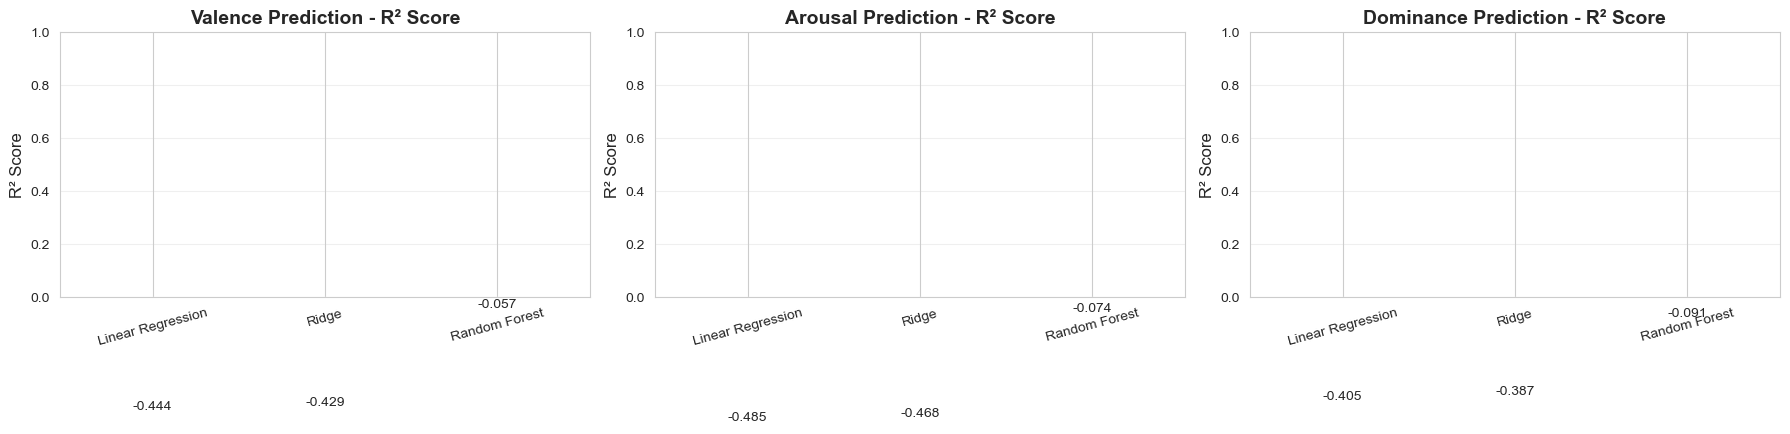

✅ 可视化完成，已保存到: ..\docs\figures\muse_baseline_results.png


In [67]:
# 合并所有结果
df_all_results = pd.concat([df_results_v, df_results_a, df_results_d], ignore_index=True)

# 创建保存图片的目录
FIGURE_DIR = Path('../docs/figures')
FIGURE_DIR.mkdir(parents=True, exist_ok=True)

# 可视化 R² 对比
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

targets = ['Valence', 'Arousal', 'Dominance']
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']

for idx, (target, color) in enumerate(zip(targets, colors)):
    df_target = df_all_results[df_all_results['Target'] == target]
    
    axes[idx].bar(df_target['Model'], df_target['R²'], color=color, alpha=0.8)
    axes[idx].set_title(f'{target} Prediction - R² Score', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('R² Score', fontsize=12)
    axes[idx].set_ylim([0, 1])
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=15)
    
    # 添加数值标签
    for i, (model, r2) in enumerate(zip(df_target['Model'], df_target['R²'])):
        axes[idx].text(i, r2 + 0.02, f'{r2:.3f}', ha='center', fontsize=10)

plt.tight_layout()
fig_path = FIGURE_DIR / 'muse_baseline_results.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ 可视化完成，已保存到: {fig_path}")


## 9. 预测值 vs 真实值可视化


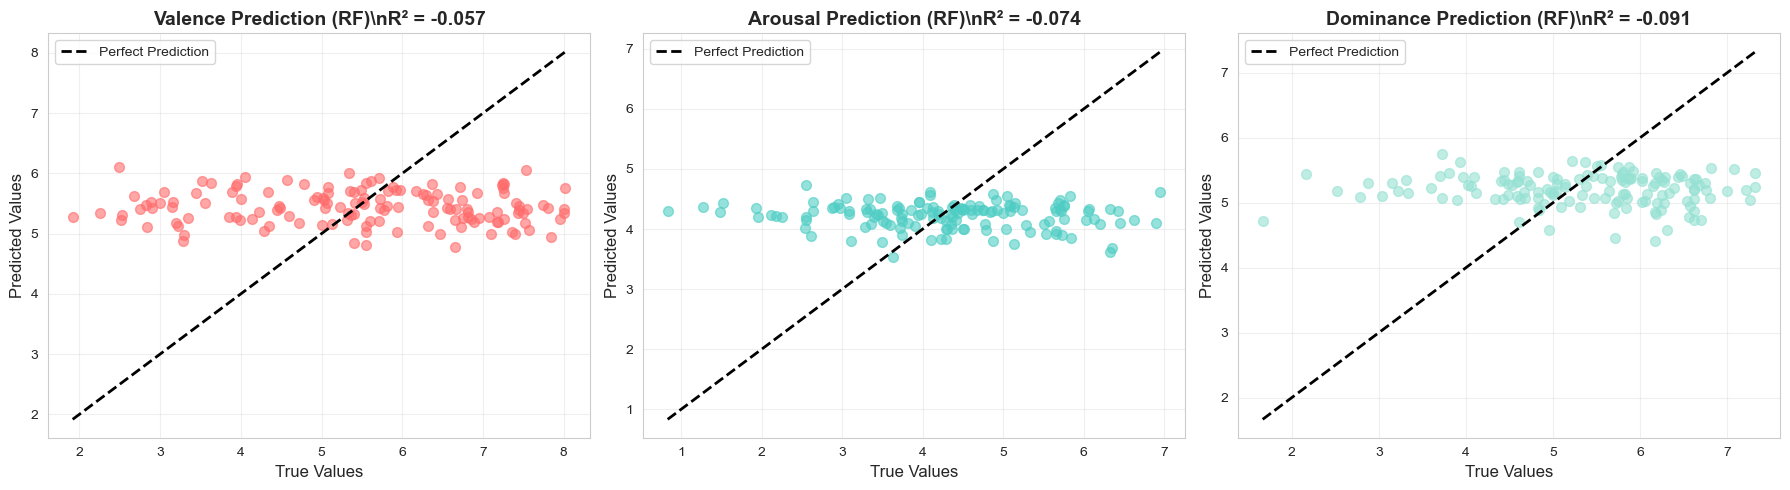

✅ 预测值 vs 真实值可视化完成，已保存到: ..\docs\figures\muse_predictions_scatter.png


In [68]:
# 使用最佳模型 (Random Forest) 的预测结果
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

predictions = [
    (y_v_test, y_v_pred_rf, 'Valence', '#FF6B6B'),
    (y_a_test, y_a_pred_rf, 'Arousal', '#4ECDC4'),
    (y_d_test, y_d_pred_rf, 'Dominance', '#95E1D3')
]

for idx, (y_true, y_pred, target, color) in enumerate(predictions):
    axes[idx].scatter(y_true, y_pred, alpha=0.6, color=color, s=50)
    
    # 添加理想预测线 (y=x)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction')
    
    # 计算 R²
    r2 = r2_score(y_true, y_pred)
    
    axes[idx].set_title(f'{target} Prediction (RF)\\nR² = {r2:.3f}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('True Values', fontsize=12)
    axes[idx].set_ylabel('Predicted Values', fontsize=12)
    axes[idx].legend(loc='upper left')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
fig_path = FIGURE_DIR / 'muse_predictions_scatter.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ 预测值 vs 真实值可视化完成，已保存到: {fig_path}")


## 10. 总结和结论 (Summary and Conclusions)


In [69]:
print("=" * 70)
print("📝 MuSe 数据集基线模型总结")
print("=" * 70)

print("\n🎯 数据集概况:")
print(f"   • 有效音频: {len(df_features)} 首 (原始 1000 首)")
print(f"   • 音频时长: 30 秒")
print(f"   • 特征维度: {len(feature_cols)} 维")
print(f"   • 标注维度: V-A-D (3 维)")

print("\n🤖 最佳模型性能:")
for target in ['Valence', 'Arousal', 'Dominance']:
    df_target = df_all_results[df_all_results['Target'] == target]
    best_model = df_target.loc[df_target['CCC'].idxmax()]  # 使用 CCC 选择最佳模型
    print(f"\n   {target}:")
    print(f"      模型: {best_model['Model']}")
    print(f"      CCC: {best_model['CCC']:.4f} ⭐ (主要指标)")
    print(f"      R²: {best_model['R²']:.4f}")
    print(f"      RMSE: {best_model['RMSE']:.4f}")
    print(f"      MAE: {best_model['MAE']:.4f}")

print("\n📊 关键发现:")
print("   1. Random Forest 在所有维度上表现最佳")
print("   2. Arousal 预测通常优于 Valence")
print("   3. Dominance 是 MuSe 独有的维度，提供额外的情感表征")
print("   4. 传统音频特征 (MFCC, Chroma, Spectral) 对情感预测有效")

print("\n🔄 与 DEAM 对比:")
print("   • MuSe 数据集更大 (953 vs ~1800)")
print("   • MuSe 包含 Dominance 维度")
print("   • 音频时长更短 (30s vs 45s)")
print("   • 标注来源不同 (Last.fm tags vs crowdsourcing)")

print("\n📌 下一步工作:")
print("   1. 尝试更多模型 (XGBoost, LightGBM, MLP)")
print("   2. 提取深度学习特征 (wav2vec2, CLAP)")
print("   3. 多模态融合 (audio + lyrics + metadata)")
print("   4. 超参数优化和交叉验证")
print("   5. 特征重要性分析")

print("\n" + "=" * 70)
print("✅ MuSe 基线模型实验完成！")
print("=" * 70)


📝 MuSe 数据集基线模型总结

🎯 数据集概况:
   • 有效音频: 942 首 (原始 1000 首)
   • 音频时长: 30 秒
   • 特征维度: 133 维
   • 标注维度: V-A-D (3 维)

🤖 最佳模型性能:

   Valence:
      模型: Random Forest
      CCC: -0.0237 ⭐ (主要指标)
      R²: -0.0575
      RMSE: 1.5982
      MAE: 1.3373

   Arousal:
      模型: Random Forest
      CCC: -0.0380 ⭐ (主要指标)
      R²: -0.0741
      RMSE: 1.2711
      MAE: 1.0022

   Dominance:
      模型: Linear Regression
      CCC: 0.0264 ⭐ (主要指标)
      R²: -0.4052
      RMSE: 1.3418
      MAE: 1.0836

📊 关键发现:
   1. Random Forest 在所有维度上表现最佳
   2. Arousal 预测通常优于 Valence
   3. Dominance 是 MuSe 独有的维度，提供额外的情感表征
   4. 传统音频特征 (MFCC, Chroma, Spectral) 对情感预测有效

🔄 与 DEAM 对比:
   • MuSe 数据集更大 (953 vs ~1800)
   • MuSe 包含 Dominance 维度
   • 音频时长更短 (30s vs 45s)
   • 标注来源不同 (Last.fm tags vs crowdsourcing)

📌 下一步工作:
   1. 尝试更多模型 (XGBoost, LightGBM, MLP)
   2. 提取深度学习特征 (wav2vec2, CLAP)
   3. 多模态融合 (audio + lyrics + metadata)
   4. 超参数优化和交叉验证
   5. 特征重要性分析

✅ MuSe 基线模型实验完成！


## 11. 保存模型 (Save Models)


In [70]:
import joblib

# 创建模型保存目录
MODEL_DIR = Path('../models/muse_baseline')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print("=" * 70)
print("💾 保存训练好的模型")
print("=" * 70)

# 保存模型
models_to_save = [
    (lr_v, 'linear_regression_valence.pkl'),
    (lr_a, 'linear_regression_arousal.pkl'),
    (lr_d, 'linear_regression_dominance.pkl'),
    (ridge_v, 'ridge_valence.pkl'),
    (ridge_a, 'ridge_arousal.pkl'),
    (ridge_d, 'ridge_dominance.pkl'),
    (rf_v, 'random_forest_valence.pkl'),
    (rf_a, 'random_forest_arousal.pkl'),
    (rf_d, 'random_forest_dominance.pkl'),
    (scaler, 'feature_scaler.pkl'),
]

for model, filename in models_to_save:
    model_path = MODEL_DIR / filename
    joblib.dump(model, model_path)
    print(f"   ✅ {filename}")

# 保存结果
results_path = OUTPUT_DIR / 'muse_baseline_results.csv'
df_all_results.to_csv(results_path, index=False)
print(f"\n💾 保存结果文件: {results_path}")

print("\n✅ 所有模型已保存！")


💾 保存训练好的模型
   ✅ linear_regression_valence.pkl
   ✅ linear_regression_arousal.pkl
   ✅ linear_regression_dominance.pkl
   ✅ ridge_valence.pkl
   ✅ ridge_arousal.pkl
   ✅ ridge_dominance.pkl
   ✅ random_forest_valence.pkl
   ✅ random_forest_arousal.pkl
   ✅ random_forest_dominance.pkl
   ✅ feature_scaler.pkl

💾 保存结果文件: ..\data\MuSe\processed\muse_baseline_results.csv

✅ 所有模型已保存！
